## CMB Lensing + 40% Galactic Mask Map Preparation + Quaia catalogue

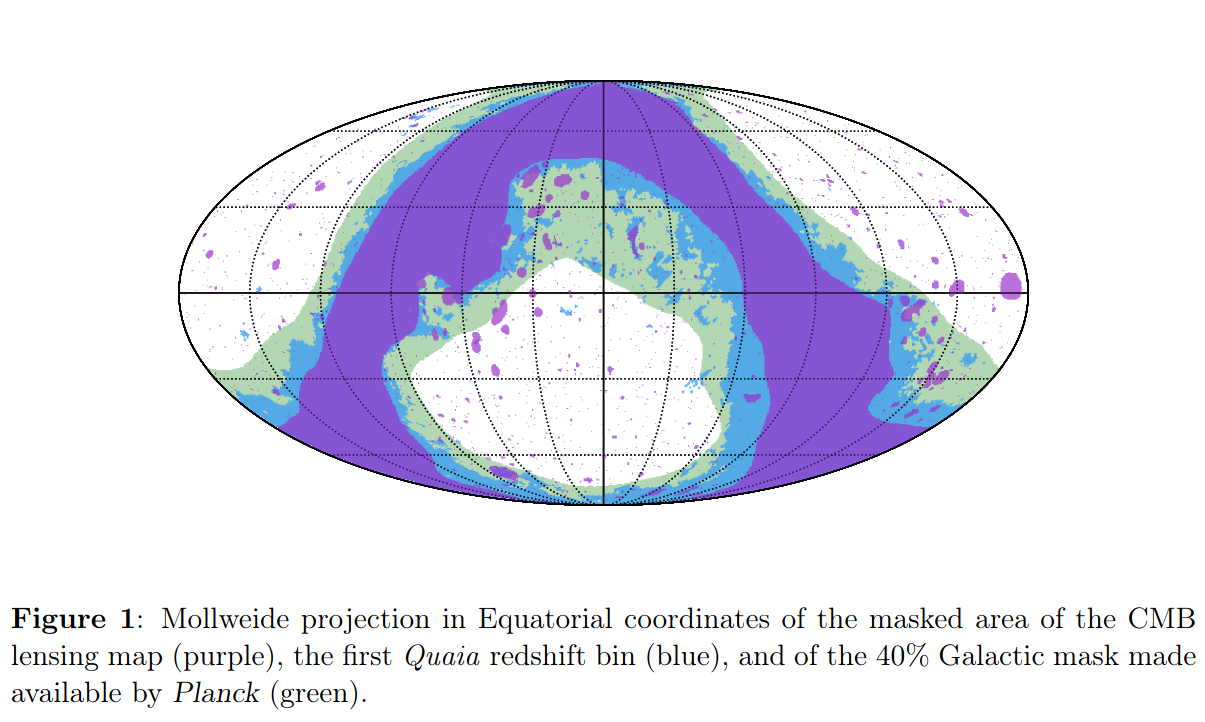

In [52]:
import healpy as hp
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib import cm
cool_cmap = cm.cool
import camb 
rot = hp.Rotator(coord=['C','G'])
from astropy.coordinates import SkyCoord
from astropy.io import fits
import sys
from scipy import stats
import copy
from astropy.table import Table

nside = 512#256
lmax = 3*nside-1 #1200
zmin = 0.9
zmax = 2.2
G_hi = 20.5
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

786432


# Quaia Map Preparation
Projected Overdensity Map as discussed in https://arxiv.org/pdf/2402.05761
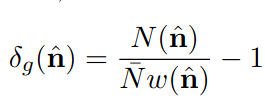
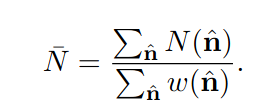

In [2]:
fn_sel = f'/home/Aruna/Downloads/selection_function_NSIDE64_G20.5.fits'
fn_quaia= f'/home/Aruna/Downloads/quaia_G20.5.fits'
tab_quaia = Table.read(fn_quaia)

In [29]:
quaia_selection_fn = hp.read_map('/home/Aruna/Downloads/selection_function_NSIDE64_G20.5.fits')
selection_function = quaia_selection_fn[quaia_selection_fn < 0.5]
selection_function

array([0.37473702, 0.44153803, 0.48248015, ..., 0.41035639, 0.48049121,
       0.40043986], dtype='>f8')

In [46]:
for mask in selection_function:
    mask_func = mask
    idx_keep_q = subsample_by_mask(NSIDE, redshift_bin1_quasar['ra'], redshift_bin1_quasar['dec'], mask_func)

TypeError: 'numpy.float64' object is not callable

In [14]:
Number_of_quasars=len(redshift_bin1_quasar)
# The mean number of quasars per pixel
mean = []
mean_quasars=0
for i in selection_function:
    mean_quasars += Number_of_quasars/i
    mean.append(mean_quasars)

/tmp/ipykernel_11949/3696401793.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  mean_quasars += Number_of_quasars/i


In [18]:
mean = np.array(mean)
projected_overdensity=Number_of_quasars/mean*selection_function-1
projected_overdensity

array([-0.85957217, -0.91049933, -0.93113302, ..., -1.        ,
       -1.        , -1.        ])

In [3]:
#Reading Maps
lensmask = hp.read_map('/home/Aruna/Downloads/PR4_variations/mask.fits')
galmask40=hp.read_map('/home/Aruna/Downloads/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=1)


# Quaia Redshift Bin1

In [4]:
#Redshift_bin1
redshift_bin1_quasar = tab_quaia[tab_quaia['redshift_quaia']< 1.0]
print('Found {0} in high redshift sample (z < 1.0)'.format(redshift_bin1_quasar))
print(f"Column names: {redshift_bin1_quasar.columns}")

Found      source_id        unwise_objid   ...  pmra_error pmdec_error
                                     ...   mas / yr    mas / yr 
------------------- ---------------- ... ----------- -----------
      6459630980096 0453p000o0014479 ...   0.6794193   0.6087985
     31026843960576 0453p000o0017859 ...   0.8461047   0.6411056
     35115652874752 0453p000o0020193 ...  0.22700854  0.22789434
     58377195752192 0453p000o0020346 ...  0.50546354   0.5524559
     83116207389824 0453p000o0020877 ... 0.074871786  0.06970348
     84456237175680 0453p000o0020456 ...  0.87478703  0.69656646
                ...              ... ...         ...         ...
6917378192686370816 3146m016o0030729 ...   1.1908576    0.568886
6917387740397472896 3146p000o0002559 ...   0.5625827  0.32216662
6917405813620286976 3146m016o0032039 ...   0.5092364     0.38529
6917406706973136256 3146m016o0027284 ...   0.5903856   0.3295121
6917407394167929216 3146m016o0027794 ...   0.7439152   0.4850732
6917412754287240704

In [78]:
pixel_indices_redshift_bin1_quasar = hp.ang2pix(NSIDE, redshift_bin1_quasar['ra'], redshift_bin1_quasar['dec'], lonlat=True)
map_redshift_bin1_quasar = np.bincount(pixel_indices_redshift_bin1_quasar, minlength=NPIX)

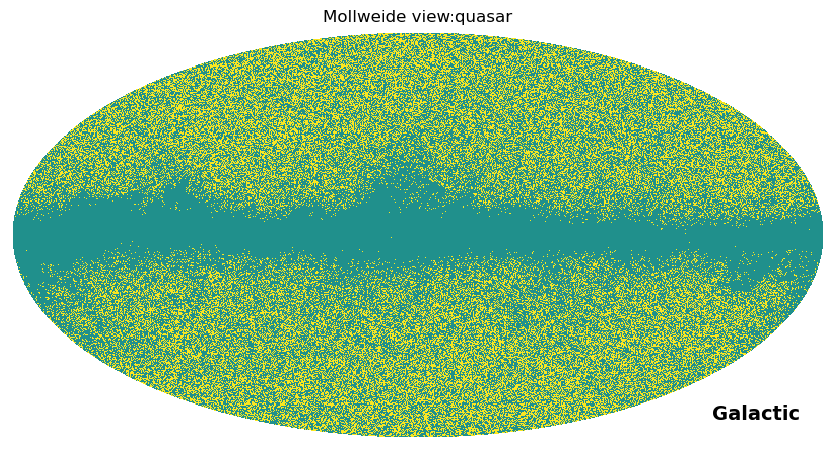

In [79]:
 hp.visufunc.mollview(map=map_redshift_bin1_quasar, fig=None, rot=None, coord=['C', 'G'], unit='', xsize=800, title='Mollweide view:quasar', nest=False, min=np.median(map_redshift_bin1_quasar)-1.5*np.std(map_redshift_bin1_quasar), max=np.median(map_redshift_bin1_quasar)+1.5*np.std(map_redshift_bin1_quasar), flip='astro', remove_dip=False, remove_mono=False, gal_cut=0, format='%g', format2='%g', cbar=None, cmap=None, notext=False, norm=None, alpha=None)

In [21]:
# degrade masks 
lensmask_lr = hp.ud_grade(lensmask,nside_out=nside)
lensmask_lr[lensmask_lr!=0]=1.

galmask40_lr = hp.ud_grade(galmask40,nside_out=nside)
galmask40_lr[galmask40_lr!=0]=1.

map_redshift_bin1_quasar_lr = hp.ud_grade(map_redshift_bin1_quasar ,nside_out=nside)
map_redshift_bin1_quasar_lr[map_redshift_bin1_quasar_lr!=0]=1.



In [22]:
# k maps for Planck DR4
klm = hp.read_alm('/its/home/aa2841/PR42018like_klm_dat_MV.fits') # read DR4 instead of DR3
fl=np.ones(4097)
fl[lmax+1:]=0.
khr=hp.alm2map(hp.almxfl(klm,fl),nside=2048,pol=False)
if nside != 2048:
    klr = hp.ud_grade(khr,nside_out=nside)
else:
    klr = khr

# k maps from Planck DR4 

klmPP = hp.read_alm('/its/home/aa2841/PR42018like_klm_dat_PP.fits') # read DR4 instead of DR3
fl=np.ones(4097)
fl[lmax+1:]=0.
khr_1=hp.alm2map(hp.almxfl(klmPP,fl),nside=2048,pol=False)
if nside != 2048:
    klr_1 = hp.ud_grade(khr_1,nside_out=nside)
else:
    klr_1 = khr_1

# k maps from Planck DR4     
klmTT = hp.read_alm('/its/home/aa2841/PR42018like_klm_dat_TT.fits') # read DR4 instead of DR3
fl=np.ones(4097)
fl[lmax+1:]=0.
khr_2=hp.alm2map(hp.almxfl(klmTT,fl),nside=2048,pol=False)
if nside != 2048:
    klr_2 = hp.ud_grade(khr_2,nside_out=nside)
else:
    klr_2 = khr_2

# k maps from Planck DR4 
klm_mf_MV = hp.read_alm('/its/home/aa2841/PR42018like_klm_mf_MV.fits') # read DR4 instead of DR3
fl=np.ones(4097)
fl[lmax+1:]=0.
khr_3=hp.alm2map(hp.almxfl(klm_mf_MV,fl),nside=2048,pol=False)
if nside != 2048:
    klr_3 = hp.ud_grade(khr_3,nside_out=nside)
else:
    klr_3 = khr_3

## k maps from Planck DR4 
klm_mf_PP = hp.read_alm('/its/home/aa2841/PR42018like_klm_mf_PP.fits') # read DR4 instead of DR3
fl=np.ones(4097)
fl[lmax+1:]=0.
khr_4=hp.alm2map(hp.almxfl(klm_mf_PP,fl),nside=2048,pol=False)
if nside != 2048:
    klr_4 = hp.ud_grade(khr_4,nside_out=nside)
else:
    klr_4 = khr_4

## k maps from Planck DR4     
klm_mf_TT = hp.read_alm('/its/home/aa2841/PR42018like_klm_mf_TT.fits') # read DR4 instead of DR3
fl=np.ones(4097)
fl[lmax+1:]=0.
khr_5=hp.alm2map(hp.almxfl(klm_mf_TT,fl),nside=2048,pol=False)
if nside != 2048:
    klr_5 = hp.ud_grade(khr_5,nside_out=nside)
else:
    klr_5 = khr_5

In [33]:
combined =klr+klr_1+klr_2+klr_3+klr_4+klr_5+galmask40_lr+lensmask_lr+map_redshift_bin1_quasar_lr

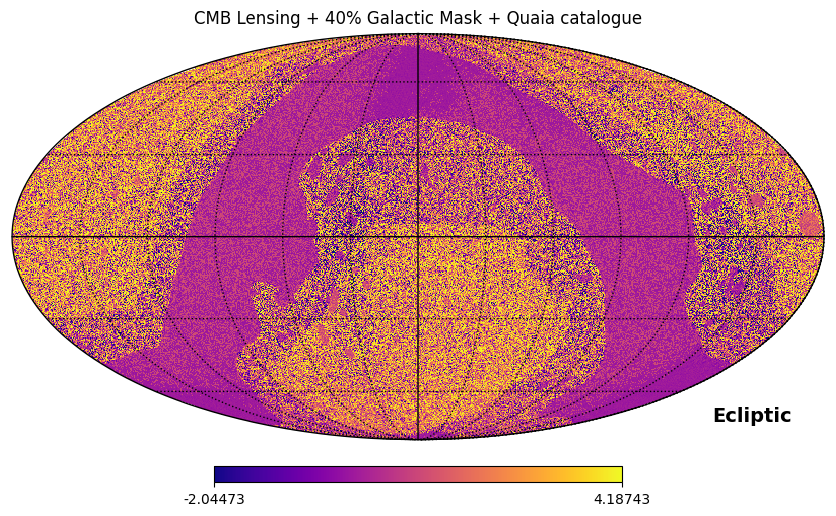

In [47]:
#You will not be able distinuish because of small overlap
hp.mollview(combined,title="CMB Lensing + 40% Galactic Mask + Quaia catalogue",cmap='plasma',min=np.median(combined)-1.5*np.std(combined), max=np.median(combined)+1.5*np.std(combined),coord=['G','E'])
hp.graticule()